In [281]:
import pandas as pd
import matplotlib.pyplot as plt

In [282]:
########## Balance mix strategy

In [283]:
busiest_day= pd.read_csv(r'../../results/busiest-day-trips-info.csv', low_memory=False)

In [284]:
# Assuming busiest_day is your dataframe
busiest_day['Route'] = busiest_day['Route'].str.replace(r'\(X\)', '', regex=True) # replace (X)
busiest_day['Route'] = busiest_day['Route'].str.replace('X', '', regex=False) # replace X

In [285]:
### FH High-cap Scenario

In [286]:
h_FH_variables = pd.read_csv(r'../../results/highcap-FH-optimized-variables.csv', low_memory=False)

In [287]:
h_FH_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [288]:
# Extract attributes from h_FH_variables
h_FH_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = h_FH_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
h_FH_variables = h_FH_variables.dropna()
h_FH_variables['Year'] = h_FH_variables['Year'].astype(int).copy()
# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
h_FH_variables['Trip'] = h_FH_variables['Trip'].astype(str)
busiest_day['TripKey'] = busiest_day['TripKey'].astype(str)


# Extract attributes from h_FH_coefficients
h_FH_coefficients[['Scenario', 'Year', 'Trip']] = h_FH_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
h_FH_coefficients = h_FH_coefficients.dropna()
h_FH_coefficients['Year'] = h_FH_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
h_FH_variables['Trip'] = h_FH_variables['Trip'].astype(str)
h_FH_coefficients['Trip'] = h_FH_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = h_FH_variables.merge(h_FH_coefficients[['Powertrain','Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Year', 'Trip',],
                                how='left')

# Update h_FH_variables
h_FH_variables = merged_df

In [289]:
# Merge the dataframes on matching values
merged_df = h_FH_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update h_FH_variables
h_FH_variables = merged_df

h_FH_variables['ServiceDateTime_min'] = pd.to_datetime(h_FH_variables['ServiceDateTime_min'])
h_FH_variables['ServiceDateTime_max'] = pd.to_datetime(h_FH_variables['ServiceDateTime_max'])
#h_FH_variables['Value'] = pd.to_numeric(h_FH_variables['Value'])

In [290]:
h_FH_variables.to_csv(r'../../results/highcap-FH-optimized-variables-aggregated.csv', index=False)

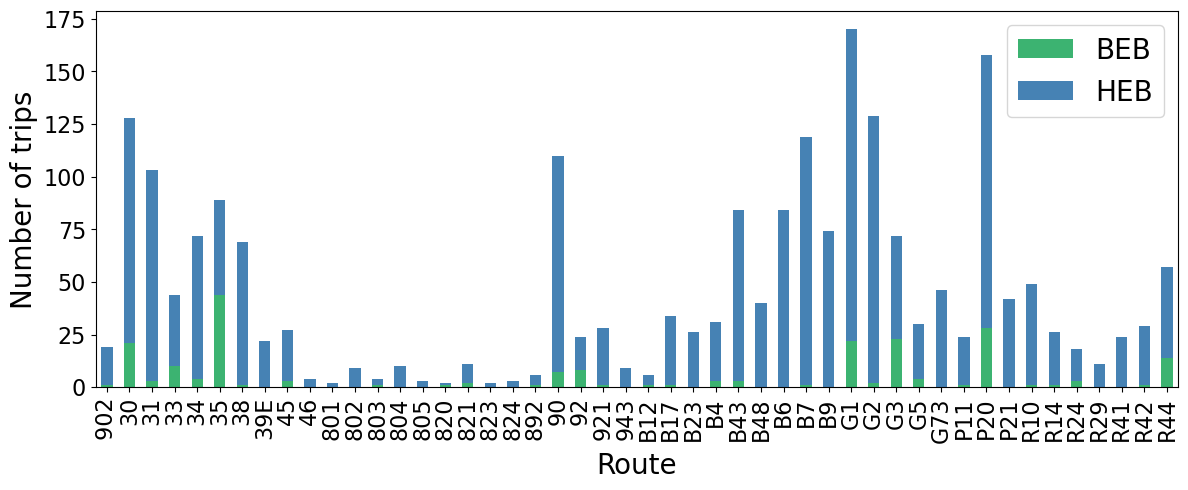

In [291]:
# Filter the dataframe for Year=13 and Value=1
h_FH_variables_filtered = h_FH_variables[(h_FH_variables['Year'] == 12) & (h_FH_variables['Value'] == 1)]
h_FH_variables_filtered = h_FH_variables_filtered[h_FH_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = h_FH_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(12, 5))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=20)
ax.set_ylabel('Number of trips', fontsize=20)
ax.legend(fontsize=20)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()

fig.savefig(r'../../figures/h_FH_route_electrification.png', dpi=400)  

plt.show()


In [292]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 9.94%


In [293]:
h_FH_variables_y = pd.read_csv(r'../../results/highcap-FH-optimized-variables-y.csv', low_memory=False)

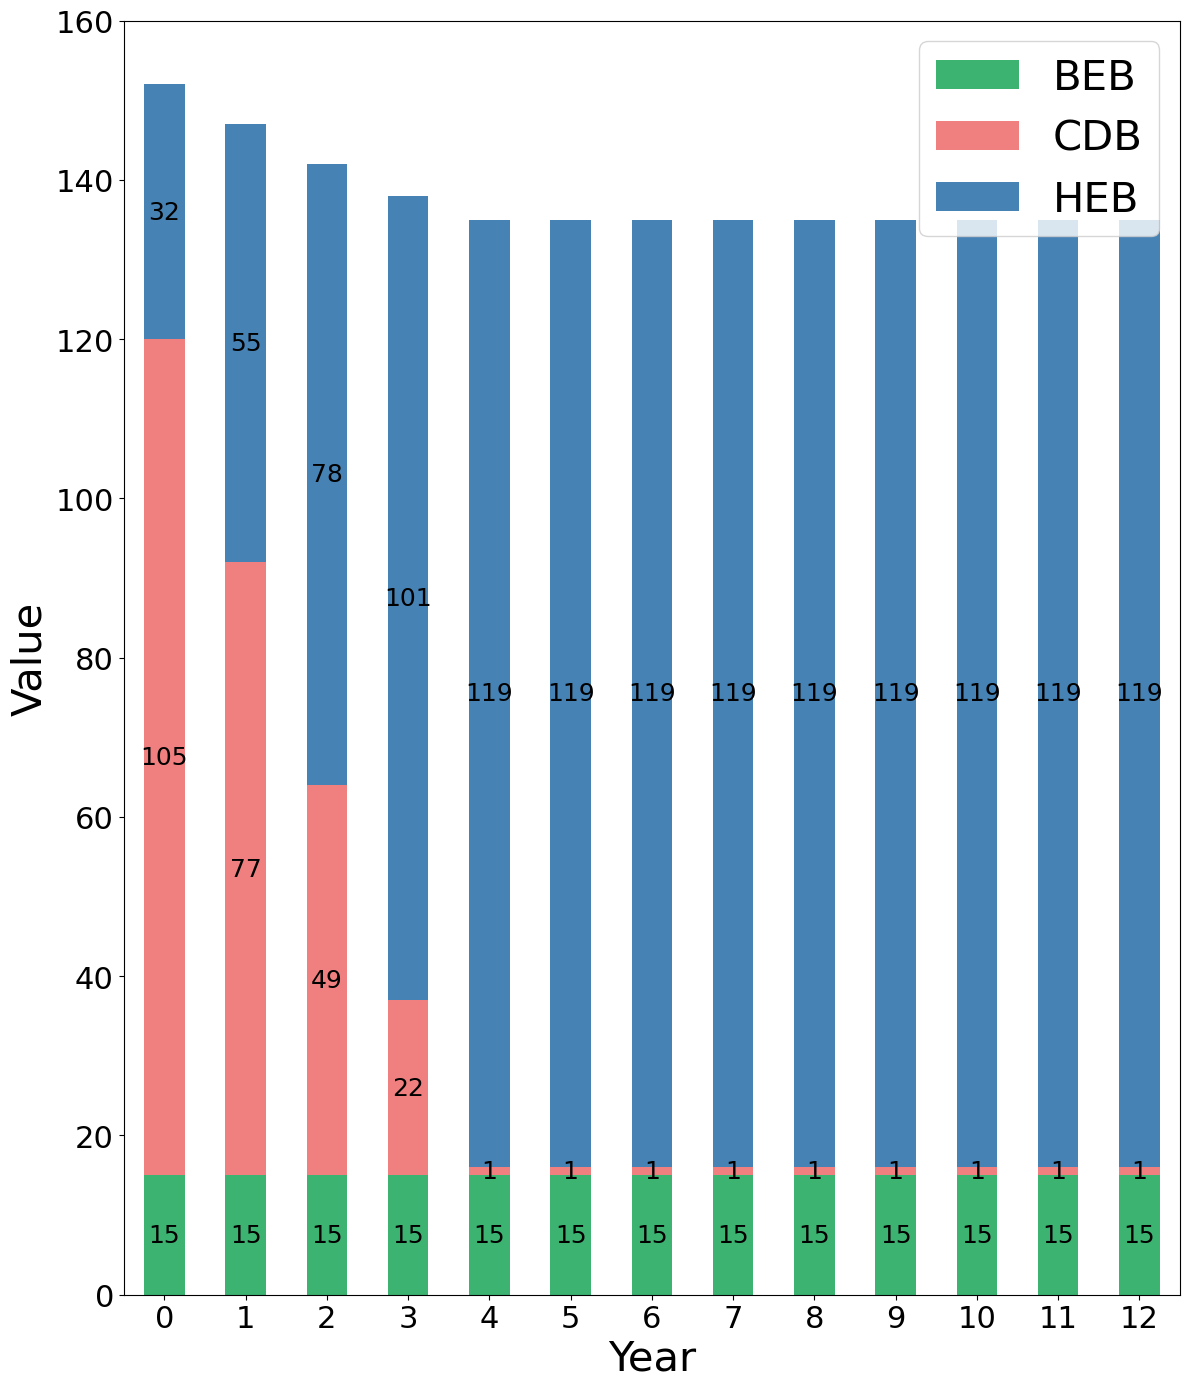

In [294]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = h_FH_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(12, 14))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values
for container in ax.containers:
    for rect in container:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                    ha='center', 
                    va='center',
                    color='black',  
                    fontsize=18)

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Value', fontsize=30)
ax.legend(fontsize=30)
ax.set_xticklabels(grouped_values.index, rotation=0)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=22)
ax.set_ylim(0, 160)


plt.tight_layout()
fig.savefig(r'../../figures/h_FH_fleet.png', dpi=400)  

plt.show()


In [295]:
total_sum = (h_FH_variables['Value'] * h_FH_variables['Coefficient']).sum()
print(total_sum)

28589.949070151


In [296]:
### FH Mid-cap Scenario

In [297]:
m_FH_variables = pd.read_csv(r'../../results/midcap-FH-optimized-variables.csv', low_memory=False)

In [298]:
m_FH_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [299]:
# Extract attributes from m_FH_variables
m_FH_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = m_FH_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
m_FH_variables = m_FH_variables.dropna()
m_FH_variables['Year'] = m_FH_variables['Year'].astype(int).copy()
# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
m_FH_variables['Trip'] = m_FH_variables['Trip'].astype(str)
busiest_day['TripKey'] = busiest_day['TripKey'].astype(str)


# Extract attributes from m_FH_coefficients
m_FH_coefficients[['Scenario', 'Year', 'Trip']] = m_FH_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
m_FH_coefficients = m_FH_coefficients.dropna()
m_FH_coefficients['Year'] = m_FH_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
m_FH_variables['Trip'] = m_FH_variables['Trip'].astype(str)
m_FH_coefficients['Trip'] = m_FH_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = m_FH_variables.merge(m_FH_coefficients[['Powertrain','Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Year', 'Trip',],
                                how='left')

# Update m_FH_variables
m_FH_variables = merged_df

In [300]:
# Merge the dataframes on matching values
merged_df = m_FH_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update h_FH_variables
m_FH_variables = merged_df

m_FH_variables['ServiceDateTime_min'] = pd.to_datetime(m_FH_variables['ServiceDateTime_min'])
m_FH_variables['ServiceDateTime_max'] = pd.to_datetime(m_FH_variables['ServiceDateTime_max'])
#h_FH_variables['Value'] = pd.to_numeric(h_FH_variables['Value'])

In [301]:
m_FH_variables.to_csv(r'../../results/midcap-FH-optimized-variables-aggregated.csv', index=False)

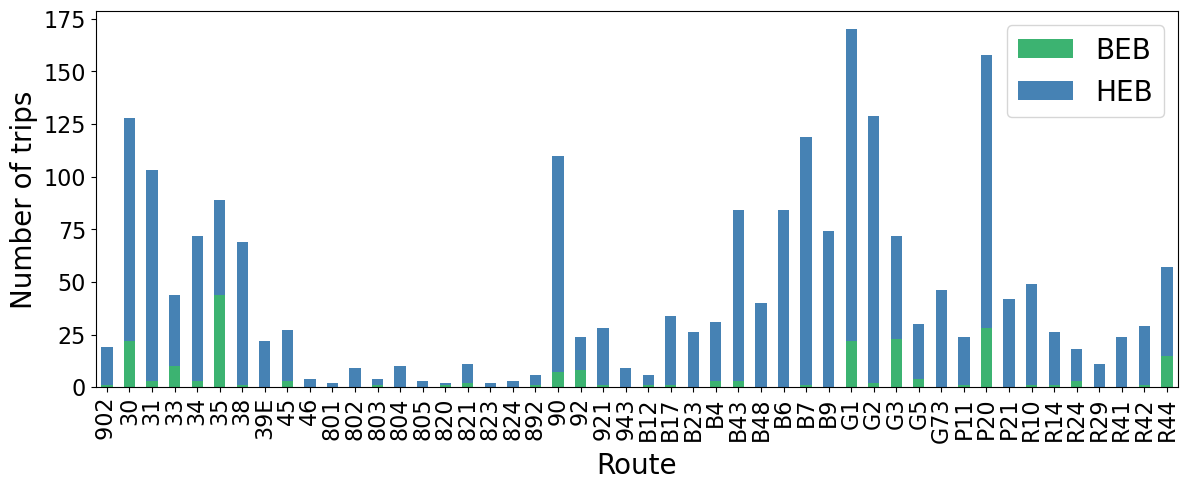

In [302]:
# Filter the dataframe for Year=13 and Value=1
m_FH_variables_filtered = m_FH_variables[(m_FH_variables['Year'] == 12) & (m_FH_variables['Value'] == 1)]
m_FH_variables_filtered = m_FH_variables_filtered[m_FH_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = m_FH_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(12, 5))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=20)
ax.set_ylabel('Number of trips', fontsize=20)
ax.legend(fontsize=20)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()
fig.savefig(r'../../figures/m_FH_route_electrification.png', dpi=400)  

plt.show()


In [303]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 9.99%


In [304]:
m_FH_variables_y = pd.read_csv(r'../../results/midcap-FH-optimized-variables-y.csv', low_memory=False)

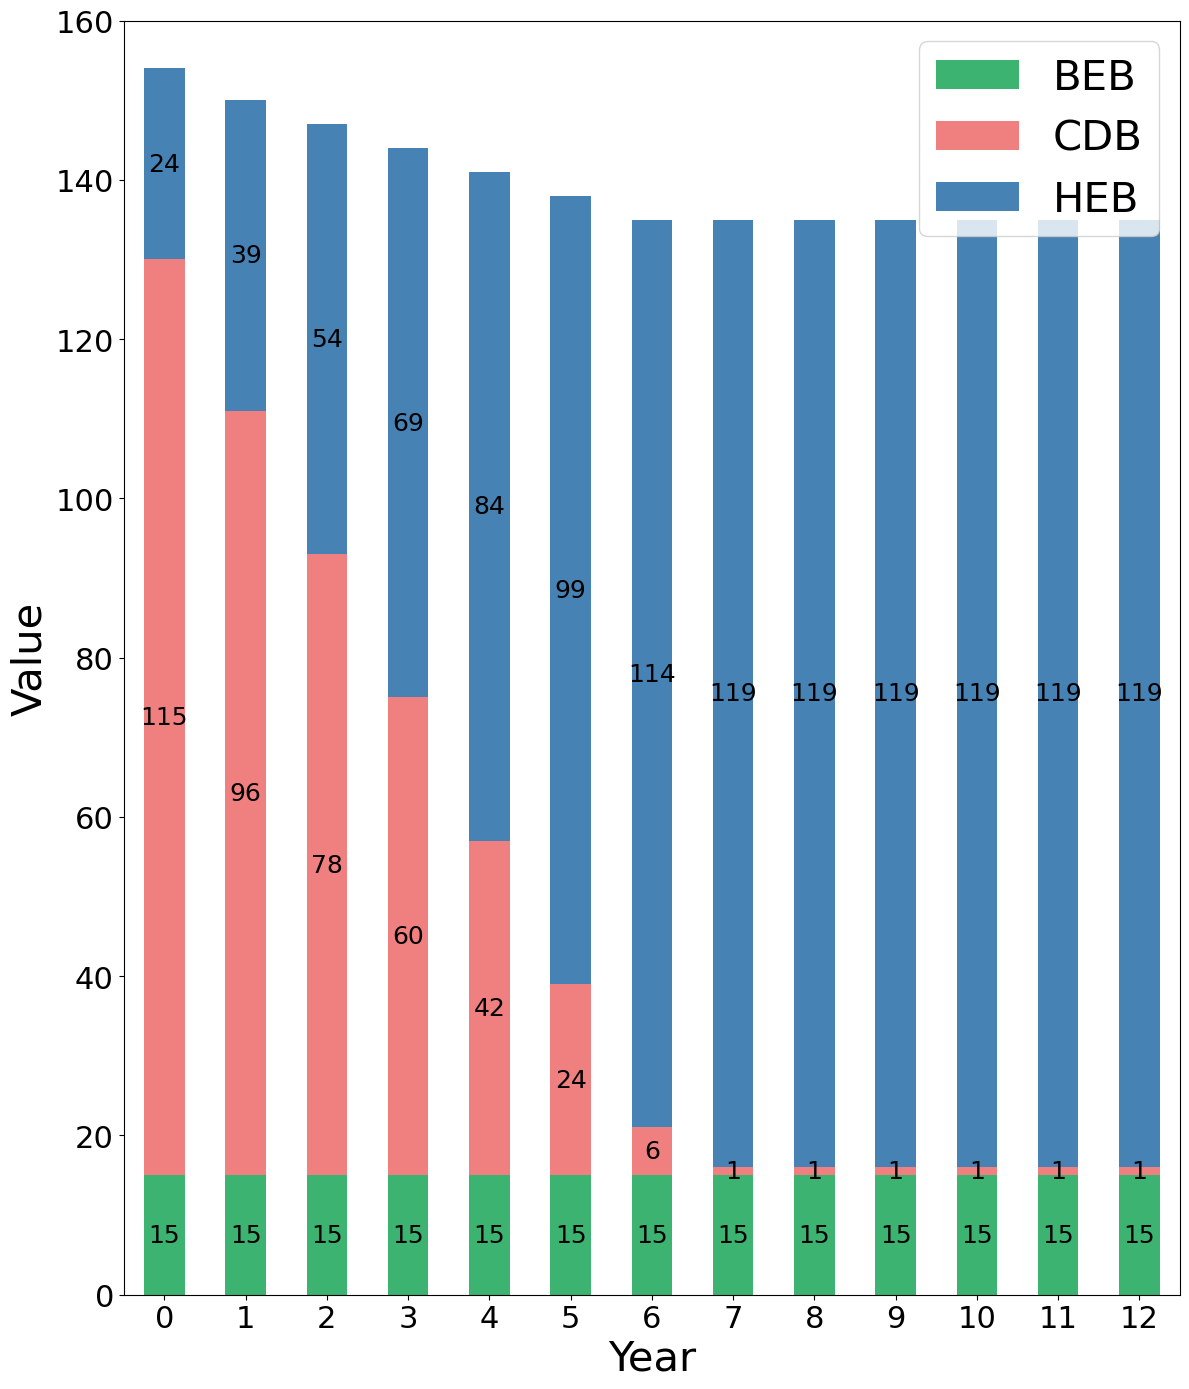

In [305]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = m_FH_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(12, 14))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values
for container in ax.containers:
    for rect in container:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                    ha='center', 
                    va='center',
                    color='black',  
                    fontsize=18)    

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Value', fontsize=30)
ax.legend(fontsize=30)
ax.set_xticklabels(grouped_values.index, rotation=0)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=22)

ax.set_ylim(0, 160)

plt.tight_layout()

fig.savefig(r'../../figures/m_FH_fleet.png', dpi=400)  

plt.show()

In [306]:
total_sum = (m_FH_variables['Value'] * m_FH_variables['Coefficient']).sum()
print(total_sum)

29327.281006281


In [307]:
### FH Low-cap Scenario

In [308]:
l_FH_variables = pd.read_csv(r'../../results/lowcap-FH-optimized-variables.csv', low_memory=False)

In [309]:
l_FH_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [310]:
# Extract attributes from l_FH_variables
l_FH_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = l_FH_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
l_FH_variables = l_FH_variables.dropna()
l_FH_variables['Year'] = l_FH_variables['Year'].astype(int)
# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
l_FH_variables['Trip'] = l_FH_variables['Trip'].astype(str)

# Extract attributes from h_FH_coefficients
l_FH_coefficients[['Scenario', 'Year', 'Trip']] = l_FH_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
l_FH_coefficients = l_FH_coefficients.dropna()
l_FH_coefficients['Year'] = l_FH_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
l_FH_variables['Trip'] = l_FH_variables['Trip'].astype(str)
l_FH_coefficients['Trip'] = l_FH_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = l_FH_variables.merge(l_FH_coefficients[['Powertrain','Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Year', 'Trip',],
                                how='left')

# Update l_FH_variables
l_FH_variables = merged_df

In [311]:
# Merge the dataframes on matching values
merged_df = l_FH_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update l_FH_variables
l_FH_variables = merged_df

l_FH_variables['ServiceDateTime_min'] = pd.to_datetime(l_FH_variables['ServiceDateTime_min'])
l_FH_variables['ServiceDateTime_max'] = pd.to_datetime(l_FH_variables['ServiceDateTime_max'])

In [312]:
l_FH_variables.to_csv(r'../../results/lowcap-FH-optimized-variables-aggregated.csv', index=False)

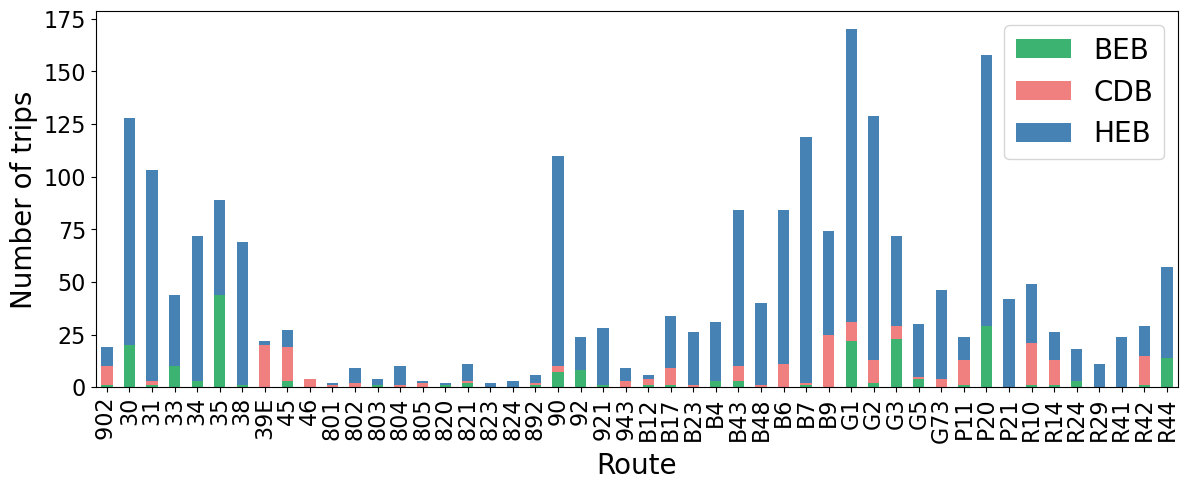

In [313]:
# Filter the dataframe for Year=13 and Value=1
l_FH_variables_filtered = l_FH_variables[(l_FH_variables['Year'] == 12) & (l_FH_variables['Value'] == 1)]
l_FH_variables_filtered = l_FH_variables_filtered[l_FH_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = l_FH_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(12, 5))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=20)
ax.set_ylabel('Number of trips', fontsize=20)
ax.legend(fontsize=20)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()
fig.savefig(r'../../figures/l_FH_route_electrification.png', dpi=400)  

plt.show()


In [314]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 9.80%


In [315]:
l_FH_variables_y = pd.read_csv(r'../../results/lowcap-FH-optimized-variables-y.csv', low_memory=False)

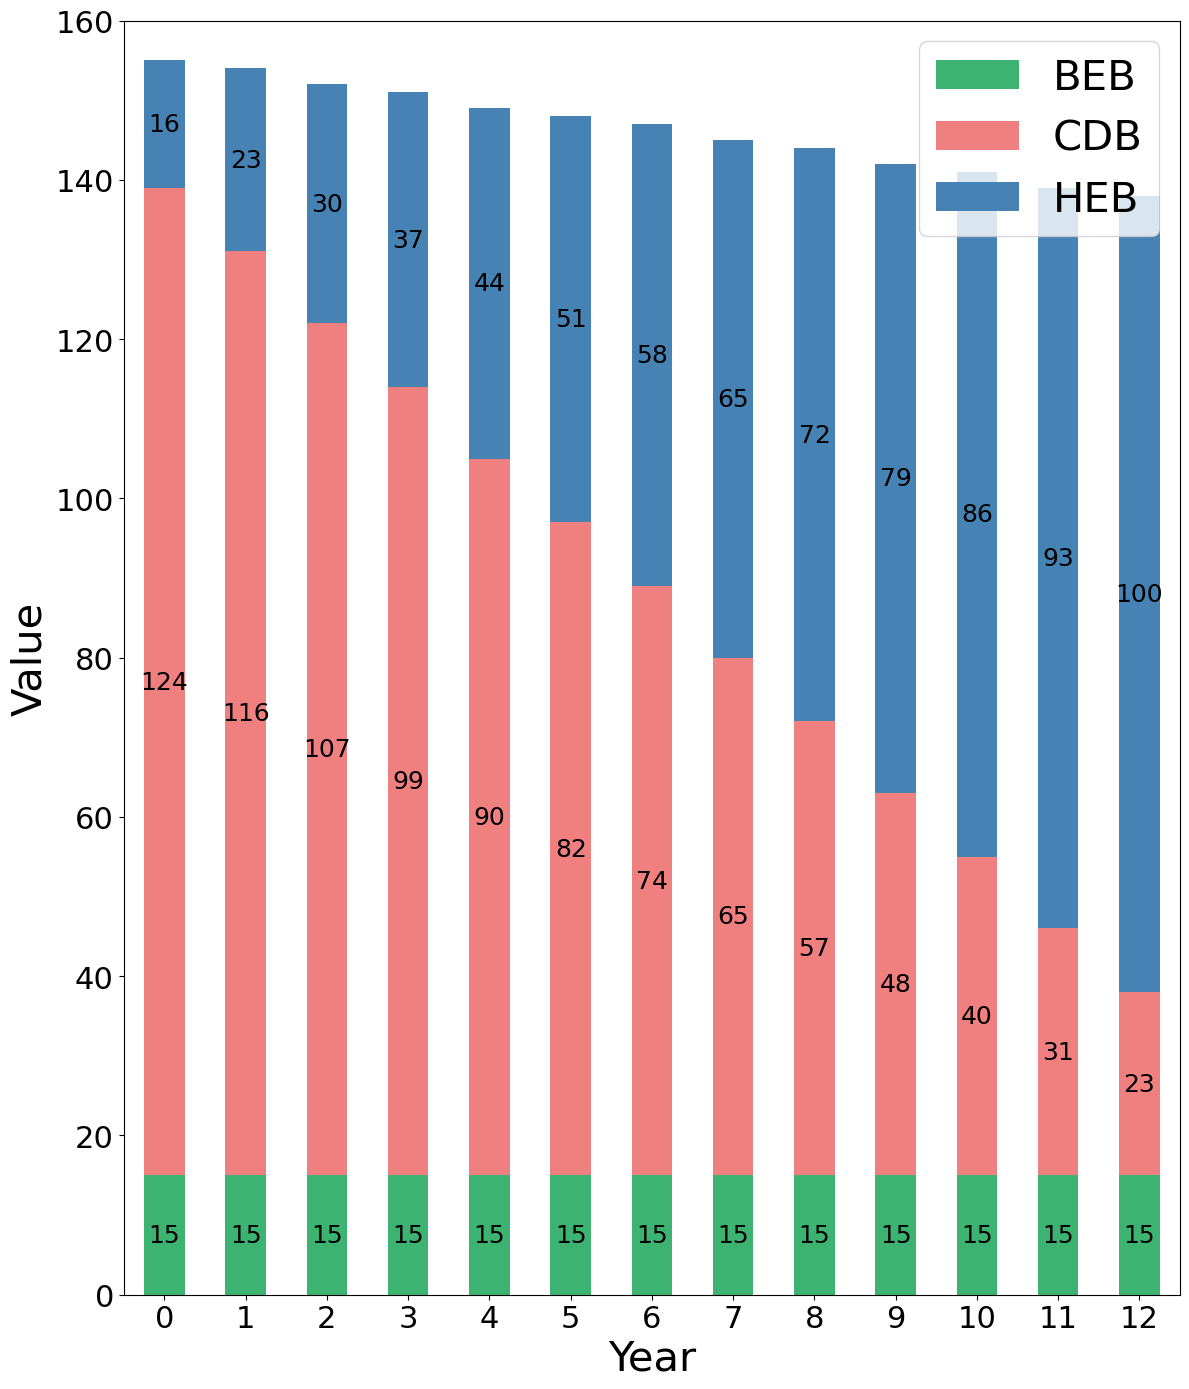

In [316]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = l_FH_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(12, 14))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values
for container in ax.containers:
    for rect in container:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                    ha='center', 
                    va='center',
                    color='black',  
                    fontsize=18)

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Value', fontsize=30)
ax.legend(loc='upper right', fontsize=30)
ax.set_xticklabels(grouped_values.index, rotation=0)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=22)

ax.set_ylim(0, 160)

plt.tight_layout()

# Save the figure
fig.savefig(r'../../figures/l_FH_fleet.png', dpi=400)  

plt.show()


In [317]:
total_sum = (l_FH_variables['Value'] * l_FH_variables['Coefficient']).sum()
print(total_sum)

31713.387375166956


In [318]:
# Calculate sum for each Year for each DataFrame
h_FH_variables['Result'] = h_FH_variables['Value'] * h_FH_variables['Coefficient']
h_FH_sum = h_FH_variables.groupby('Year')['Result'].sum().reset_index()

m_FH_variables['Result'] = m_FH_variables['Value'] * m_FH_variables['Coefficient']
m_FH_sum = m_FH_variables.groupby('Year')['Result'].sum().reset_index()

l_FH_variables['Result'] = l_FH_variables['Value'] * l_FH_variables['Coefficient']
l_FH_sum = l_FH_variables.groupby('Year')['Result'].sum().reset_index()

# Add Scenario and Strategy columns
h_FH_sum['Scenario'] = 'h'
h_FH_sum['Strategy'] = 'FH'

m_FH_sum['Scenario'] = 'm'
m_FH_sum['Strategy'] = 'FH'

l_FH_sum['Scenario'] = 'l'
l_FH_sum['Strategy'] = 'FH'

# Concatenate the DataFrames
final_df = pd.concat([h_FH_sum, m_FH_sum, l_FH_sum])

# Rearrange the columns
final_df = final_df[['Year', 'Result', 'Scenario', 'Strategy']]
final_df.to_csv(r'../../results/diesel-FH.csv', index=False)

In [320]:
final_df

,Year,Result,Scenario,Strategy
0,0,2609.521505,h,FH
1,1,2446.444292,h,FH
2,2,2301.665772,h,FH
3,3,2181.268745,h,FH
4,4,2116.837171,h,FH
5,5,2116.767773,h,FH
6,6,2116.767773,h,FH
7,7,2116.767773,h,FH
8,8,2116.767773,h,FH
9,9,2116.767773,h,FH
